#### Objective 4 -> To predict and segment employees into groups for optimal training and development needs

##### This requires ML algo to grp the employees (clustering) based on their development needs and to predict (classification) to which group the dataset (i.e the a new or existing employee belongs to ), so that HR can predict the right training program for the employees. We are going to use 2 different types of approaches such as Supervised and Unsupersived Learning

 - Unsupervised Learning (Clustering) -> Find natural groupings in your data without pre-defined labels. This is perfect for discovering unknown segments.

 - Supervised Learning (Classification): After defining segments, build a model to predict which segment an employee falls into.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px


# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split, cross_val_score

# ML Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Utilities
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
ibm_dataset = pd.read_csv('./dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
ibm_dataset.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [4]:
def categorize_development_priority(row):
  if row['PerformanceRating'] <= 2:
    if row['Education'] >= 3: 
      return 'High'
    elif row['YearsSinceLastPromotion'] > 3: 
      return 'High'
    else : return 'Medium'
  elif row['JobLevel'] < 2 and row['Education'] >= 4:
    return 'Medium'
  else:
    return 'Low'
  

ibm_dataset['DevelopmentPriority'] = ibm_dataset.apply(categorize_development_priority, axis=1)

In [5]:
ibm_dataset.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,DevelopmentPriority
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,Low
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,Low
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,Low
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,Medium
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,Low


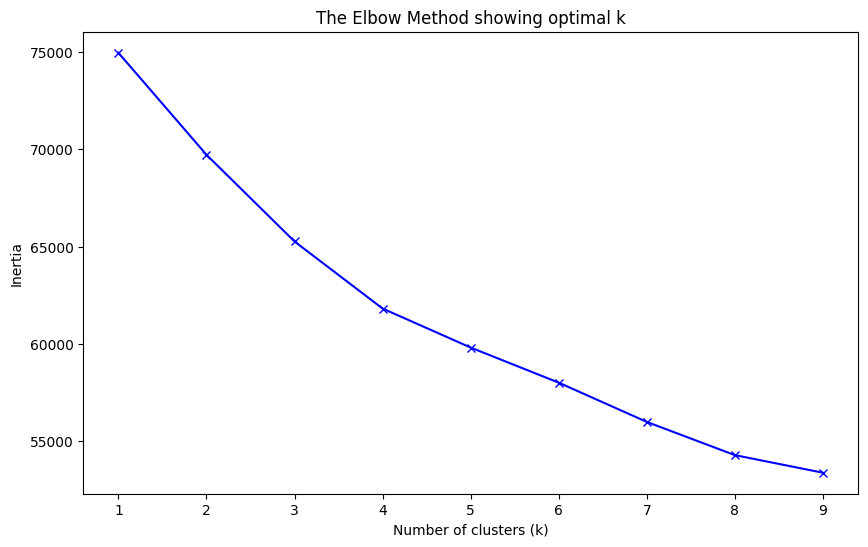

In [6]:
# Encode Categoricals
df_encoded = pd.get_dummies(ibm_dataset, columns=['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'])

# Define Features and Target
X = df_encoded.drop(['DevelopmentPriority', 'Attrition', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
y = df_encoded['DevelopmentPriority']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train and Test sets (for supervised learning)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Find the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled) # Use the scaled data!
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing optimal k')
plt.show()

In [7]:
# Perform K-Means clustering with the chosen k
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original dataframe
ibm_dataset['Cluster'] = clusters

In [8]:
# Analyze the mean values of features for each cluster
cluster_profile = ibm_dataset.groupby('Cluster').mean(numeric_only=True)
print(cluster_profile[['Age', 'MonthlyIncome', 'YearsAtCompany', 'PerformanceRating', 'WorkLifeBalance', 'Education']])

# Look at the distribution of your created 'DevelopmentPriority' in each cluster
print(pd.crosstab(ibm_dataset['Cluster'], ibm_dataset['DevelopmentPriority']))

               Age  MonthlyIncome  YearsAtCompany  PerformanceRating  \
Cluster                                                                
0        45.786290   14794.278226       14.036290           3.153226   
1        36.862069    5710.275862        6.172414           3.137931   
2        35.182500    5928.450000        6.120000           3.135000   
3        34.963351    4172.450262        5.255236           3.164921   

         WorkLifeBalance  Education  
Cluster                              
0               2.770161   3.104839  
1               2.913793   2.948276  
2               2.822500   2.907500  
3               2.714660   2.850785  
DevelopmentPriority  Low  Medium
Cluster                         
0                    247       1
1                     51       7
2                    386      14
3                    657     107


##### These are the following cluster comparisions


 - Cluster 0: High Education, Low Job Level, Medium Performance -> "High-Potential New Hires". Need onboarding and mentorship.

 - Cluster 1: Low Performance Rating, Low Satisfaction, Medium Tenure -> "Disengaged & At-Risk". Need engagement interventions and skills reassessment.

 - Cluster 2: High Performance, High Income, High Job Level -> "Leaders & High Performers". Need leadership development and retention programs.

 - Cluster 3: Many Years at Company, Long Time Since Promotion -> "Stagnant Veterans". Need new challenge assignments and upskilling.

##### Cluster Size Analysis

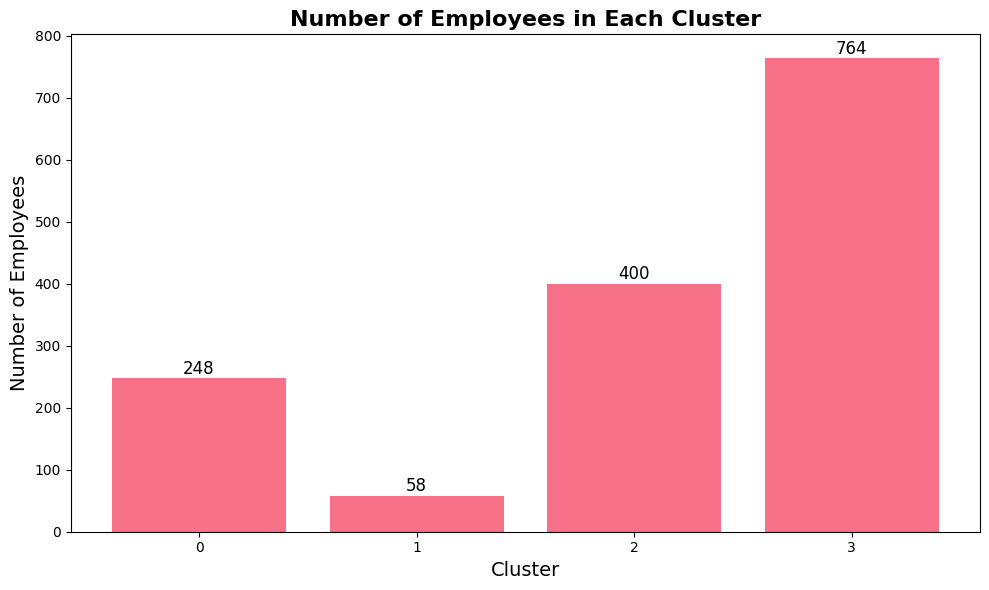

Cluster Distribution (%):
Cluster 3: 51.97%
Cluster 2: 27.21%
Cluster 0: 16.87%
Cluster 1: 3.95%


In [9]:
# Set plot style
plt.style.use('default')
sns.set_palette("husl")

# Cluster distribution
cluster_counts = ibm_dataset['Cluster'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.title('Number of Employees in Each Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Employees', fontsize=14)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Percentage distribution
cluster_percentages = ibm_dataset['Cluster'].value_counts(normalize=True) * 100
print("Cluster Distribution (%):")
for cluster, percentage in cluster_percentages.items():
    print(f"Cluster {cluster}: {percentage:.2f}%")

##### Demographic profile for each cluster 

In [10]:
# Select key features to analyze
key_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'YearsSinceLastPromotion', 
                'TotalWorkingYears', 'Education', 'JobLevel', 'PerformanceRating',
                'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']

# Create a summary table
cluster_summary = ibm_dataset.groupby('Cluster')[key_features].mean().round(2)
print("Average Values for Key Features by Cluster:")
print(cluster_summary)

Average Values for Key Features by Cluster:
           Age  MonthlyIncome  YearsAtCompany  YearsSinceLastPromotion  \
Cluster                                                                  
0        45.79       14794.28           14.04                     4.96   
1        36.86        5710.28            6.17                     1.50   
2        35.18        5928.45            6.12                     1.94   
3        34.96        4172.45            5.26                     1.47   

         TotalWorkingYears  Education  JobLevel  PerformanceRating  \
Cluster                                                              
0                    23.45       3.10      3.88               3.15   
1                     9.98       2.95      1.81               3.14   
2                     9.33       2.91      2.04               3.14   
3                     8.45       2.85      1.51               3.16   

         EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  
Cluster              

##### Visual comparisions of key metrics

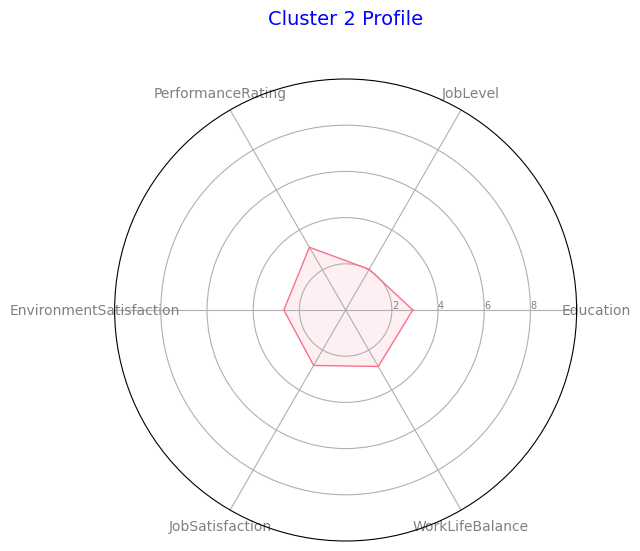

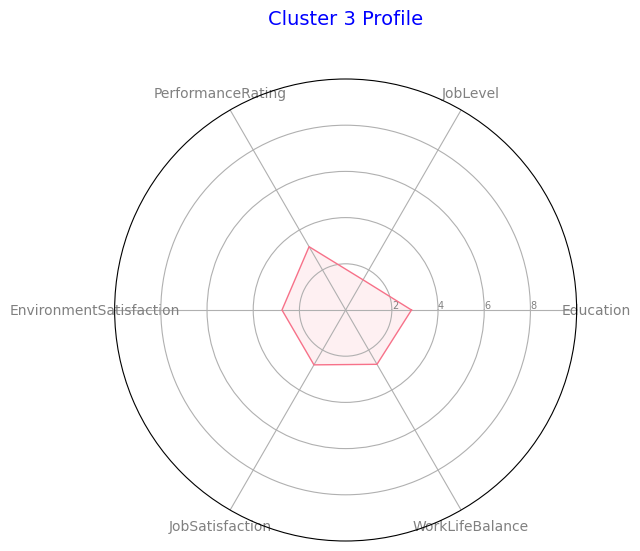

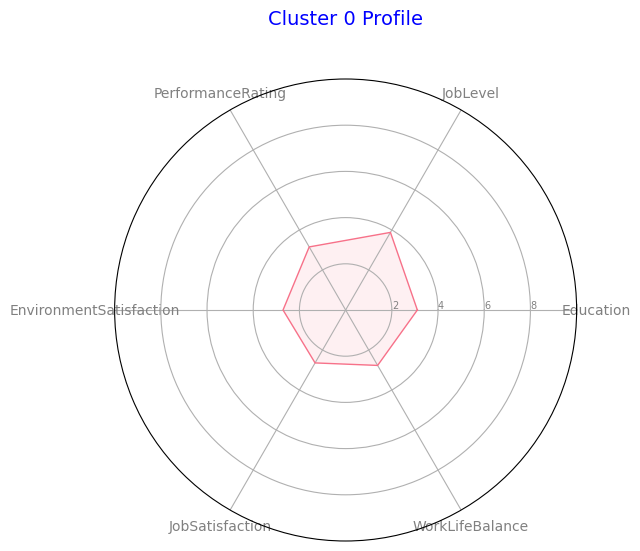

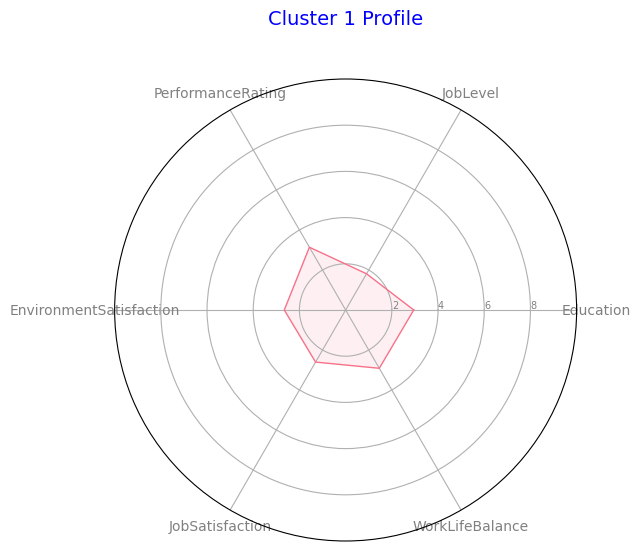

In [11]:
### Creating a radar chart

# Function to create radar chart
def create_radar_chart(cluster_data, attributes, cluster_name):
    categories = attributes
    N = len(categories)
    
    # Calculate angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([2, 4, 6, 8], ["2", "4", "6", "8"], color="grey", size=7)
    plt.ylim(0, 10)
    
    # Plot data
    values = cluster_data[attributes].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=cluster_name)
    ax.fill(angles, values, alpha=0.1)
    
    plt.title(f'Cluster {cluster_name} Profile', size=14, color='blue', y=1.1)
    plt.show()

# Select attributes for radar chart
radar_attributes = ['Education', 'JobLevel', 'PerformanceRating', 
                    'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']

# Create radar chart for each cluster
for cluster_id in ibm_dataset['Cluster'].unique():
    cluster_data = ibm_dataset[ibm_dataset['Cluster'] == cluster_id][radar_attributes].mean().to_frame().T
    create_radar_chart(cluster_data, radar_attributes, cluster_id)

##### Categorical variable analysis

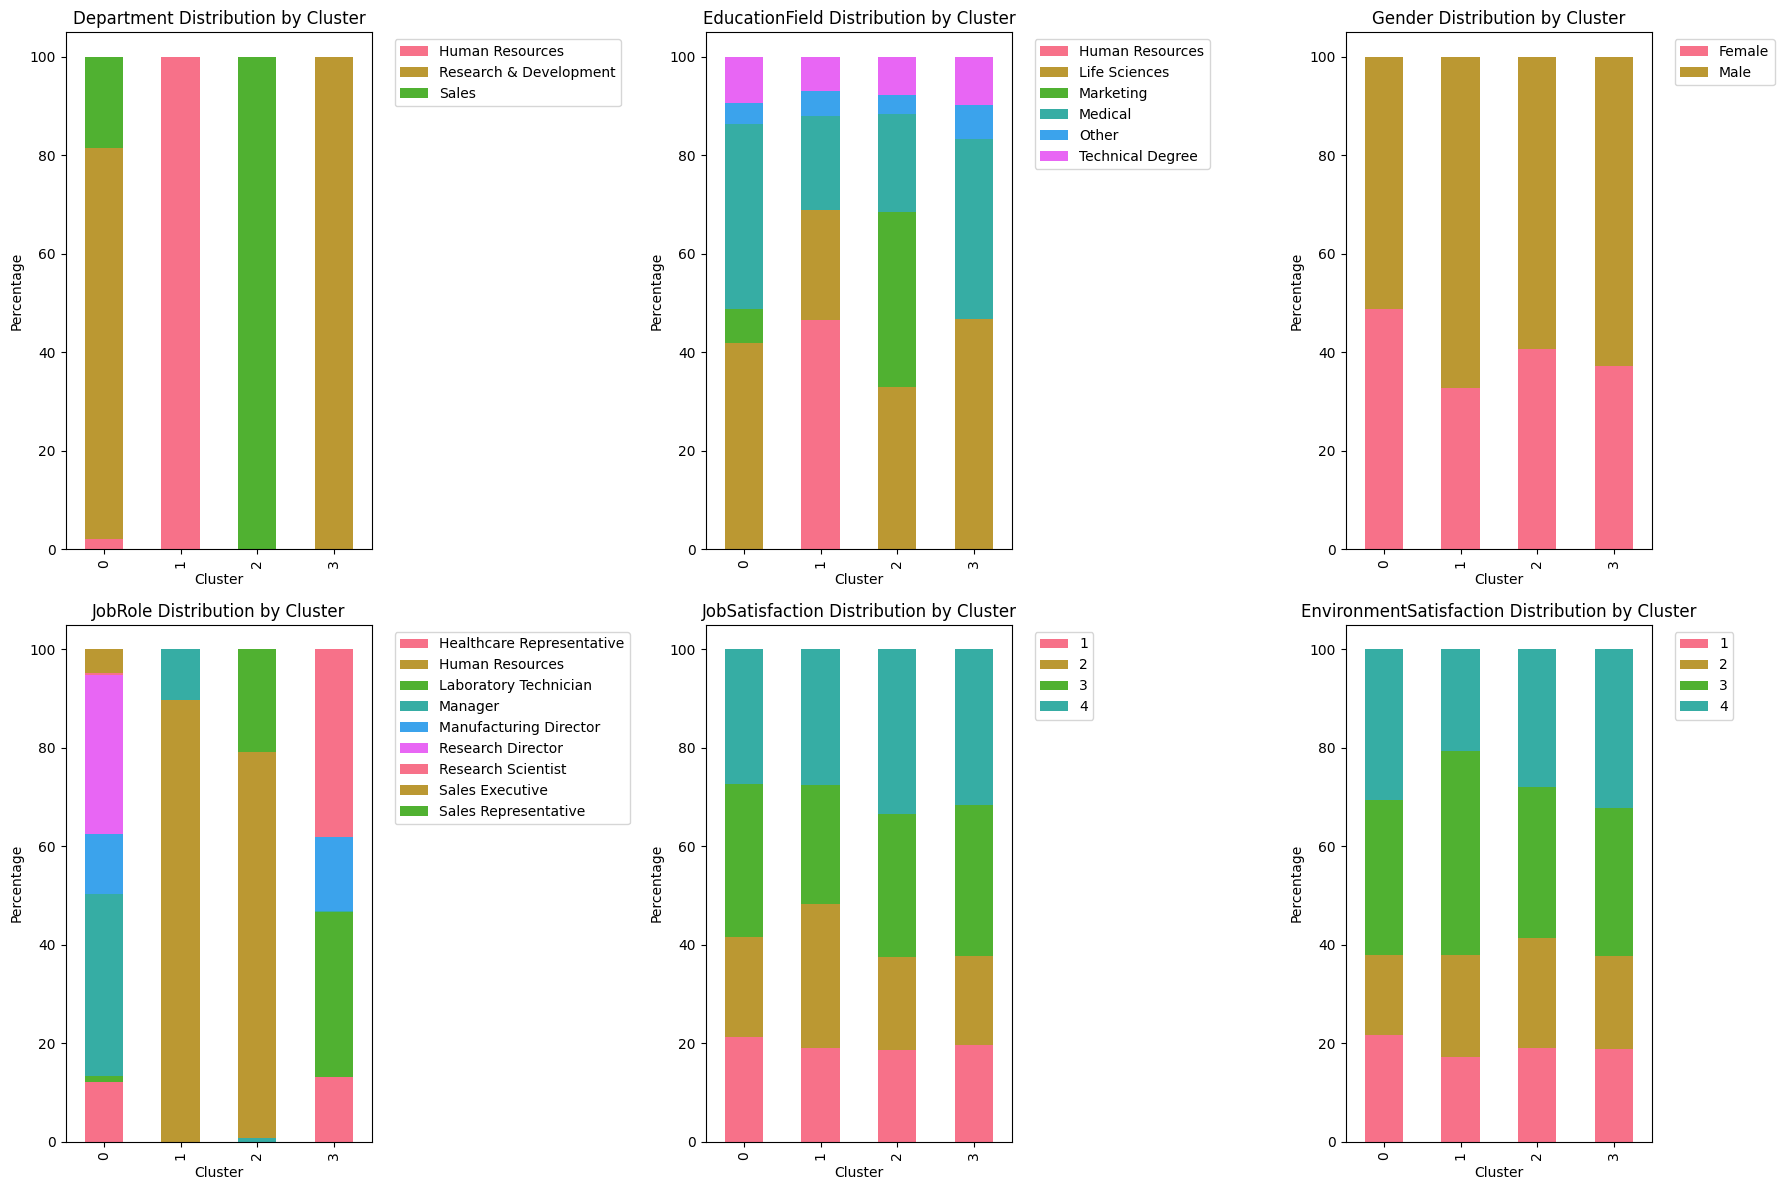

In [16]:
# Analyze categorical variables across clusters
categorical_vars = ['Department', 'EducationField', 'Gender', 'JobRole', 'JobSatisfaction',
                    'EnvironmentSatisfaction']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(categorical_vars):
    # Create cross-tabulation
    cross_tab = pd.crosstab(ibm_dataset['Cluster'], ibm_dataset[var], normalize='index') * 100
    
    # Plot
    cross_tab.plot(kind='bar', ax=axes[i], stacked=True)
    axes[i].set_title(f'{var} Distribution by Cluster')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.tight_layout()
plt.show()

##### Relationship with Development Priority -> It is to check how the clusters are aligned with the Development Priority which is added as an extra column to the ibm dataset

Development Priority Distribution by Cluster (%):
DevelopmentPriority        Low     Medium
Cluster                                  
0                    99.596774   0.403226
1                    87.931034  12.068966
2                    96.500000   3.500000
3                    85.994764  14.005236


<Figure size 1000x600 with 0 Axes>

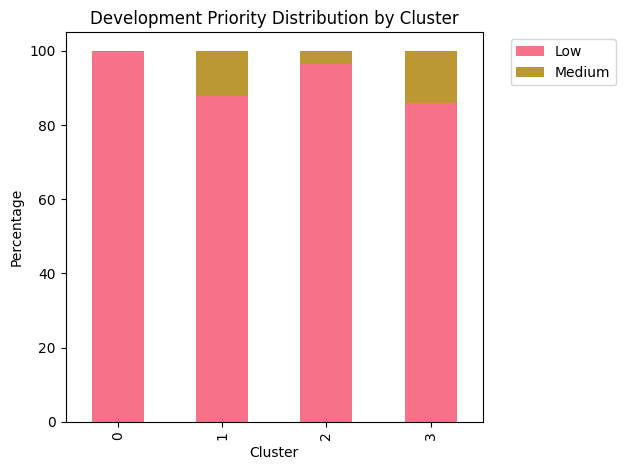

In [13]:
# Cross-tabulation between Cluster and DevelopmentPriority
dev_priority_by_cluster = pd.crosstab(ibm_dataset['Cluster'], ibm_dataset['DevelopmentPriority'], 
                                      normalize='index') * 100

print("Development Priority Distribution by Cluster (%):")
print(dev_priority_by_cluster)

# Visualize
plt.figure(figsize=(10, 6))
dev_priority_by_cluster.plot(kind='bar', stacked=True)
plt.title('Development Priority Distribution by Cluster')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### Enhanced Cluster Profiles with the help of Pie Chart

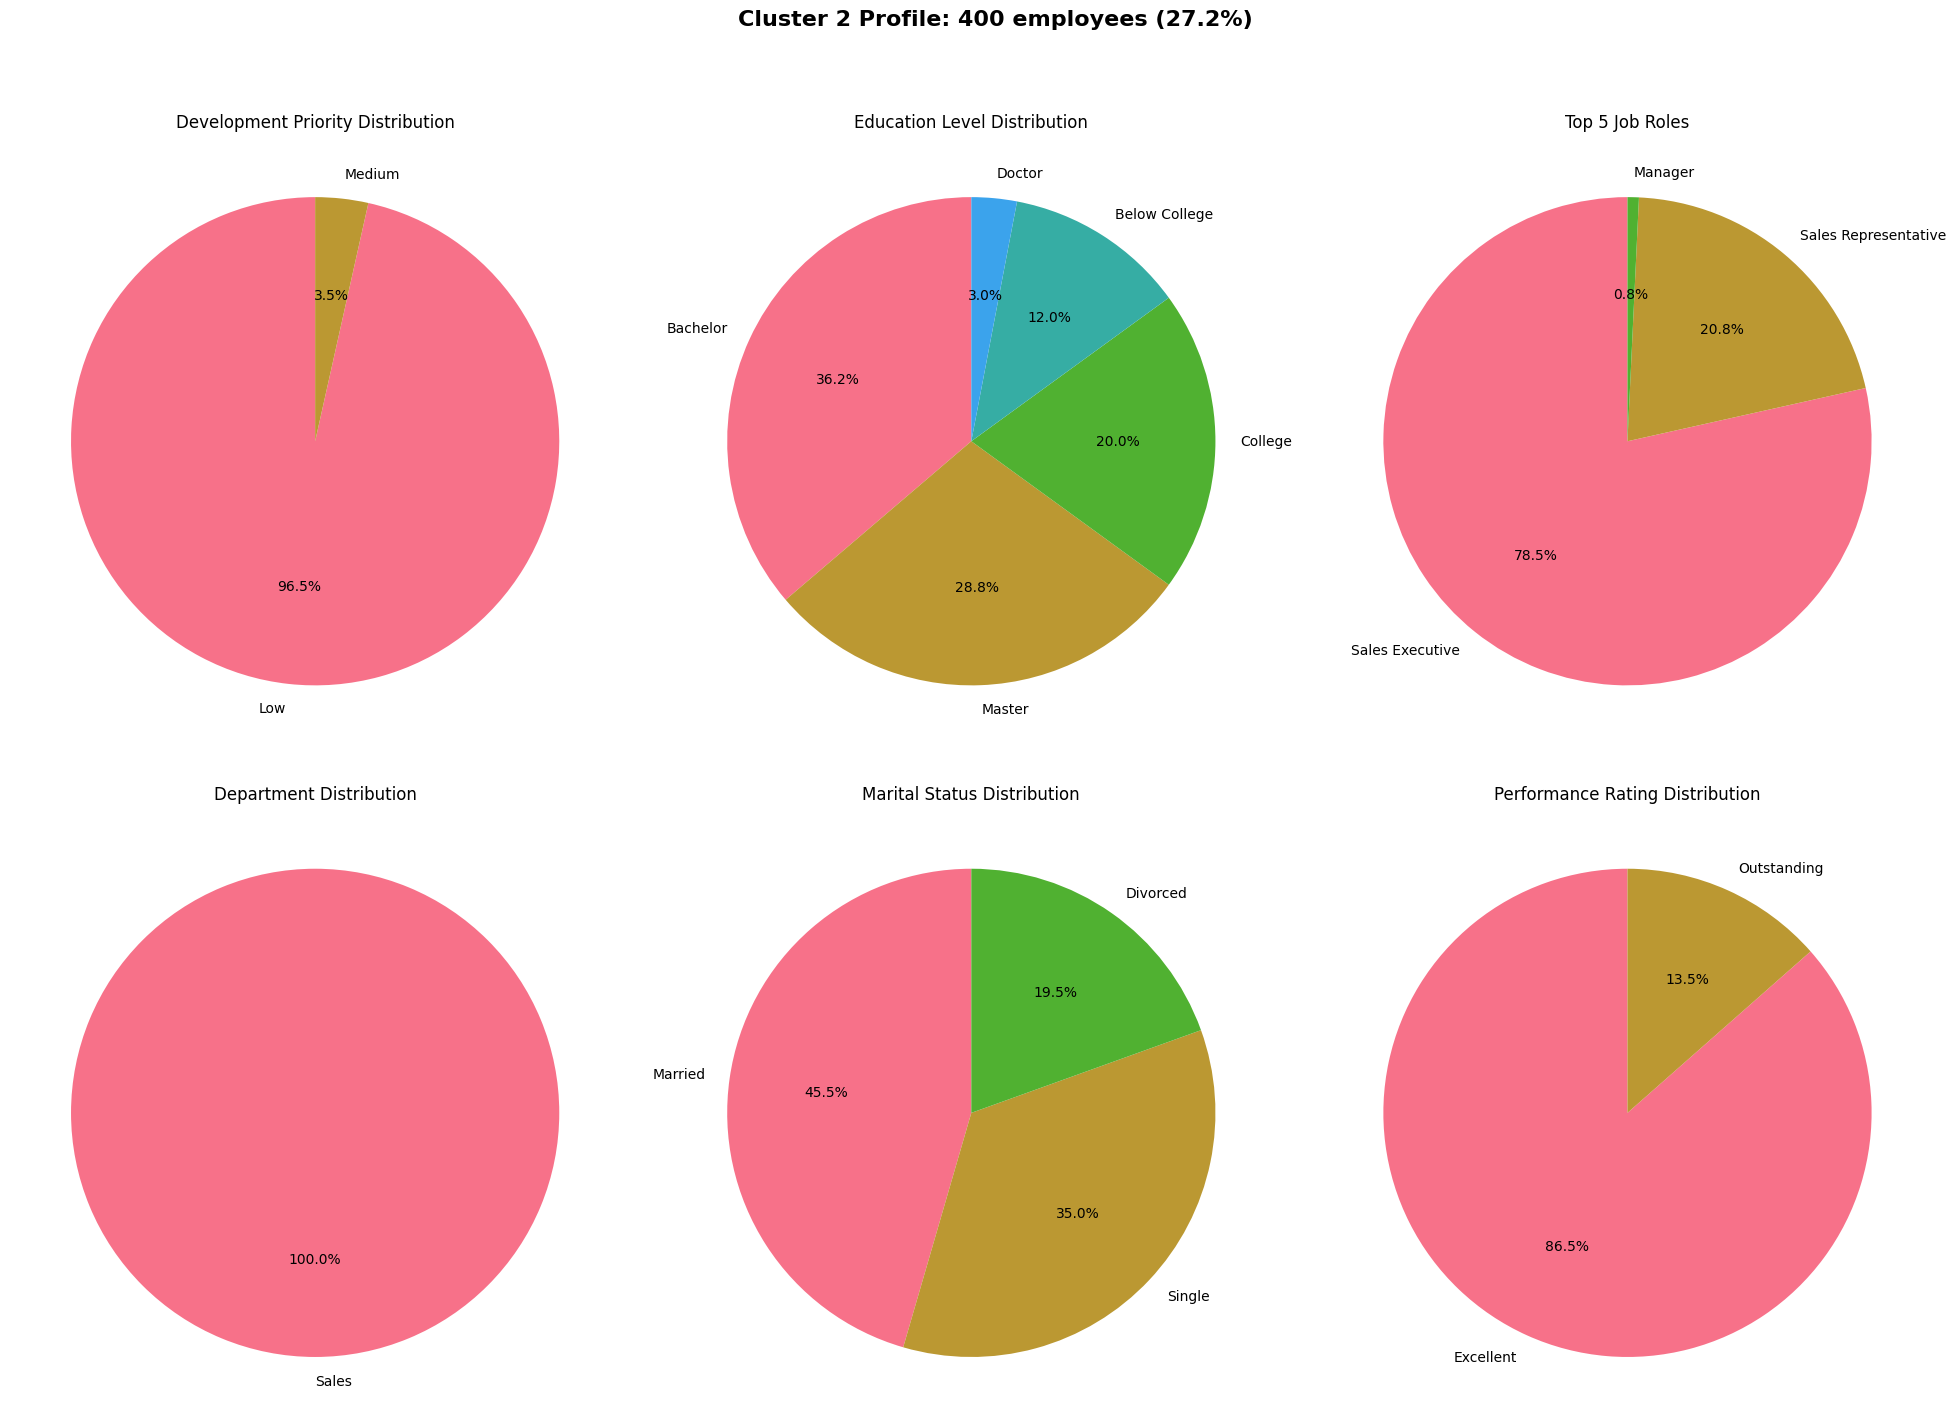


CLUSTER 2 PROFILE
Size: 400 employees (27.2%)

Key Statistics (Averages):
Age: 35.18
MonthlyIncome: 5928.45
YearsAtCompany: 6.12
YearsSinceLastPromotion: 1.94
TotalWorkingYears: 9.33
Education: 2.91
JobLevel: 2.04
PerformanceRating: 3.13
EnvironmentSatisfaction: 2.67
JobSatisfaction: 2.77
WorkLifeBalance: 2.82

Most Common Categories:
Department: Sales (100.0%)
EducationField: Marketing (35.5%)
Gender: Male (59.2%)
JobRole: Sales Executive (78.5%)
JobSatisfaction: 4 (33.5%)
EnvironmentSatisfaction: 3 (30.5%)

Development Priority:
Low: 96.5%
Medium: 3.5%




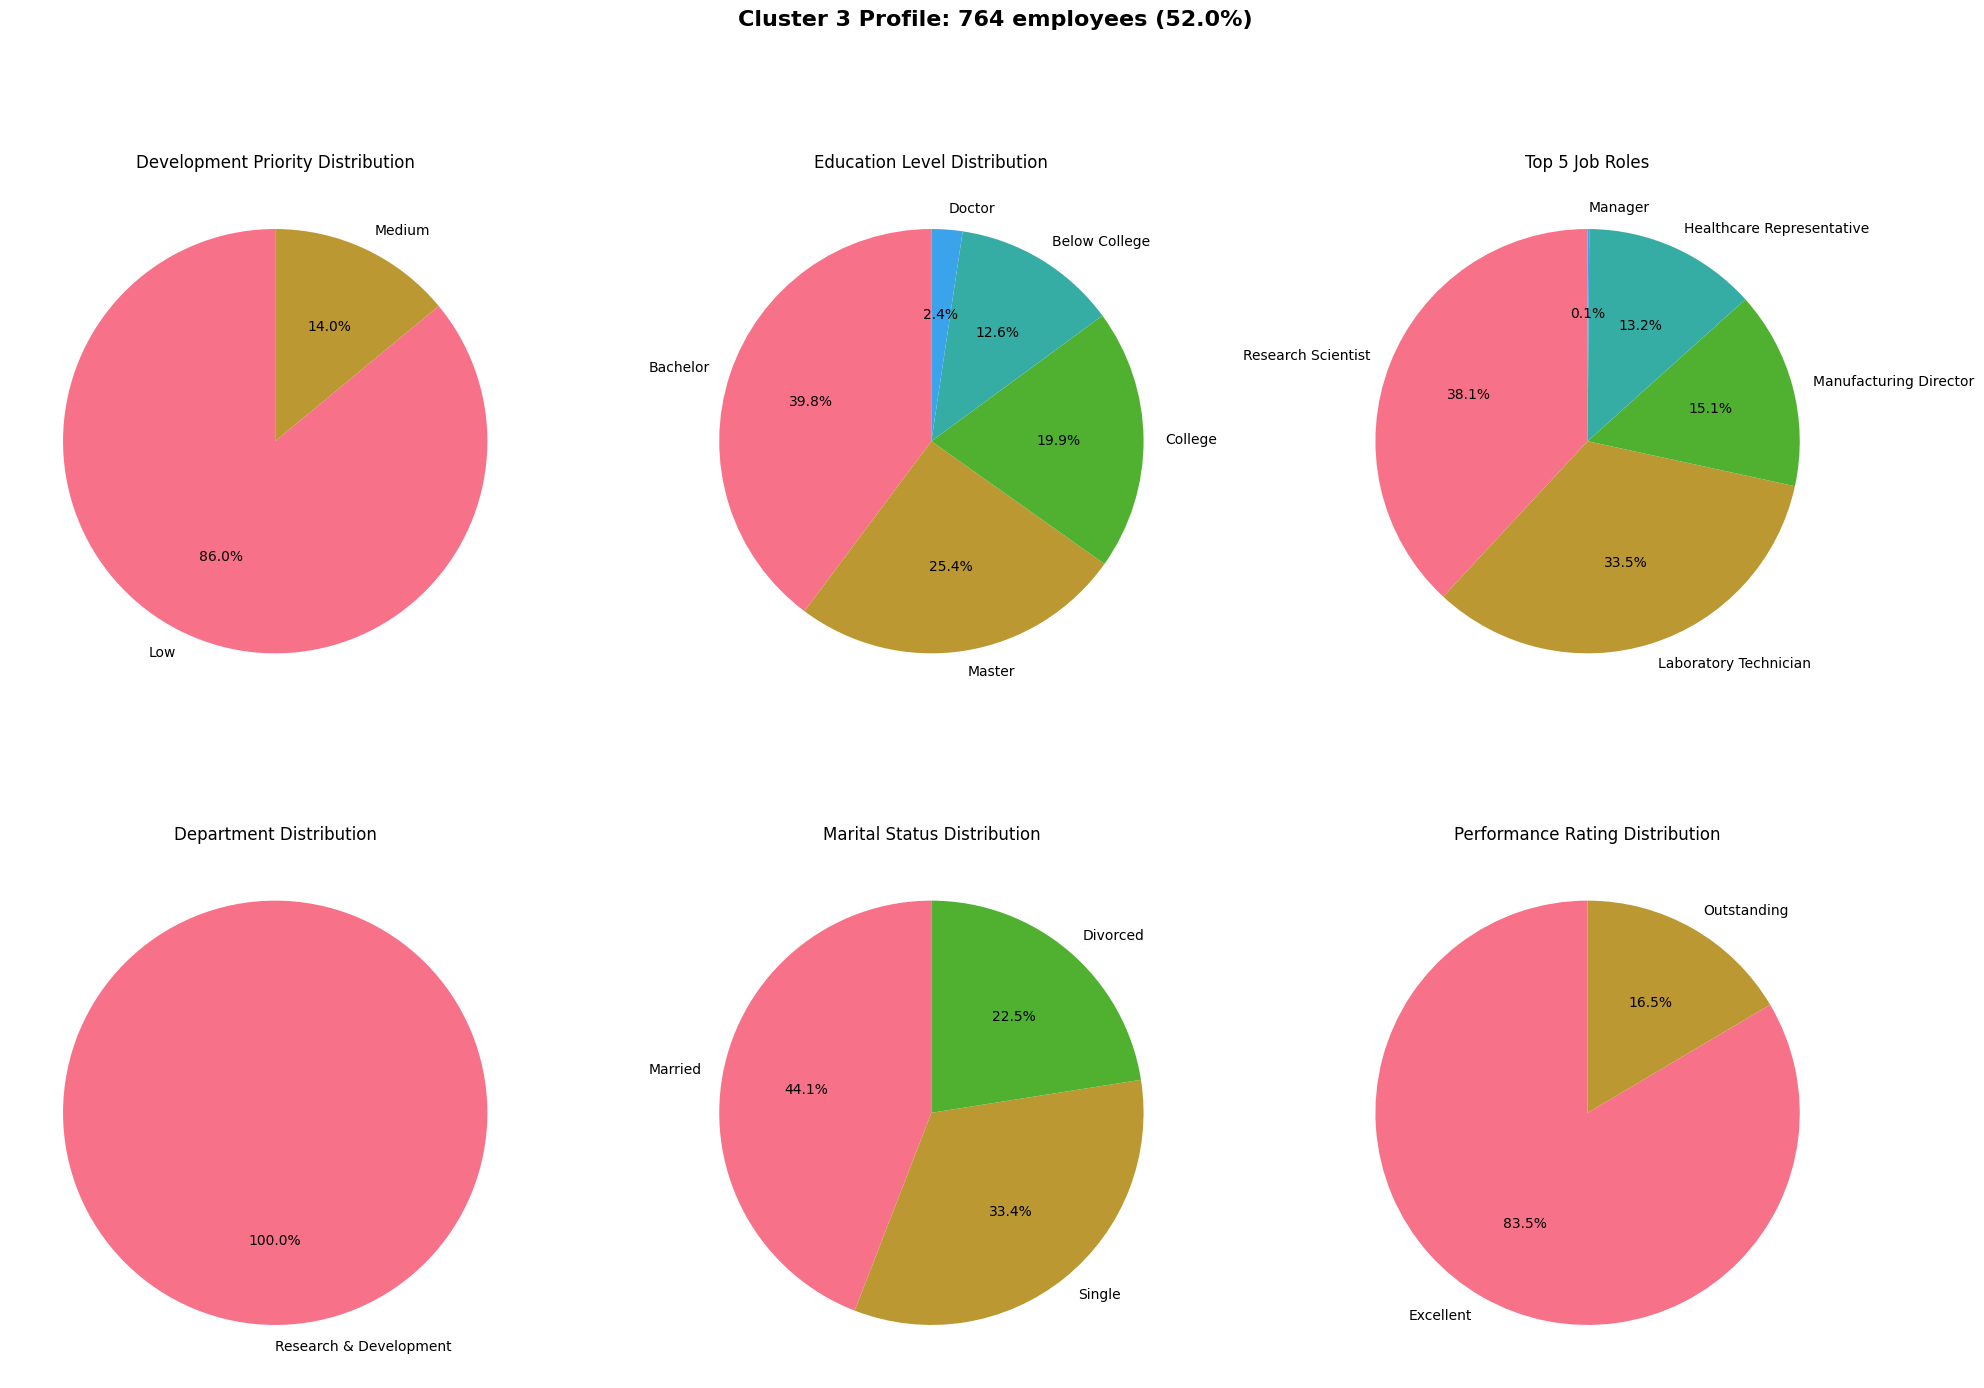


CLUSTER 3 PROFILE
Size: 764 employees (52.0%)

Key Statistics (Averages):
Age: 34.96
MonthlyIncome: 4172.45
YearsAtCompany: 5.26
YearsSinceLastPromotion: 1.47
TotalWorkingYears: 8.45
Education: 2.85
JobLevel: 1.51
PerformanceRating: 3.16
EnvironmentSatisfaction: 2.76
JobSatisfaction: 2.74
WorkLifeBalance: 2.71

Most Common Categories:
Department: Research & Development (100.0%)
EducationField: Life Sciences (46.7%)
Gender: Male (62.7%)
JobRole: Research Scientist (38.1%)
JobSatisfaction: 4 (31.5%)
EnvironmentSatisfaction: 4 (32.2%)

Development Priority:
Low: 86.0%
Medium: 14.0%




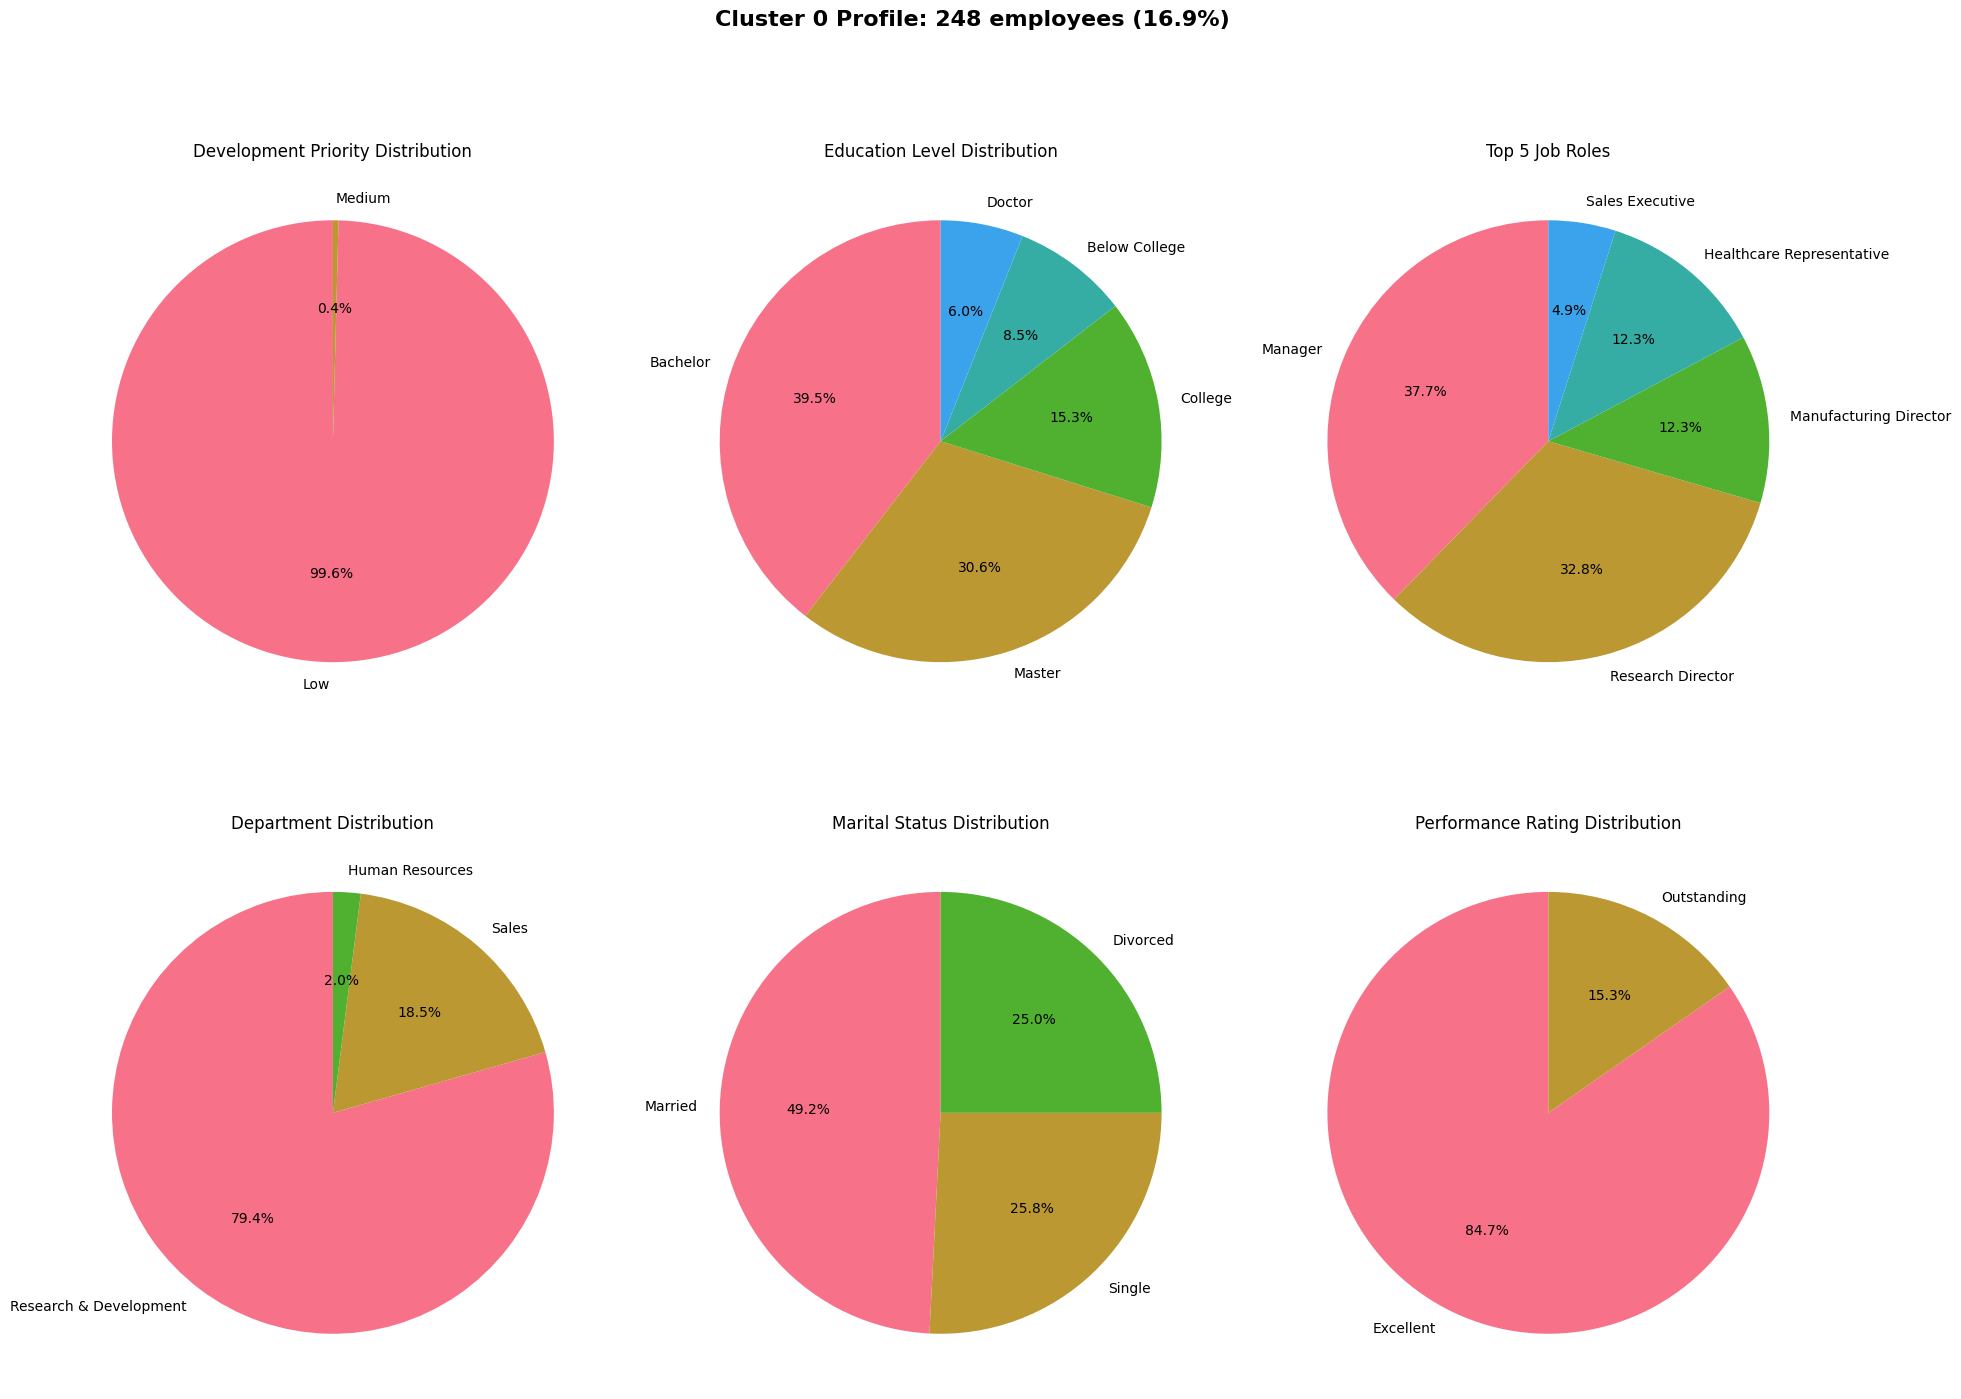


CLUSTER 0 PROFILE
Size: 248 employees (16.9%)

Key Statistics (Averages):
Age: 45.79
MonthlyIncome: 14794.28
YearsAtCompany: 14.04
YearsSinceLastPromotion: 4.96
TotalWorkingYears: 23.45
Education: 3.10
JobLevel: 3.88
PerformanceRating: 3.15
EnvironmentSatisfaction: 2.71
JobSatisfaction: 2.65
WorkLifeBalance: 2.77

Most Common Categories:
Department: Research & Development (79.4%)
EducationField: Life Sciences (41.9%)
Gender: Male (51.2%)
JobRole: Manager (37.1%)
JobSatisfaction: 3 (31.0%)
EnvironmentSatisfaction: 3 (31.5%)

Development Priority:
Low: 99.6%
Medium: 0.4%




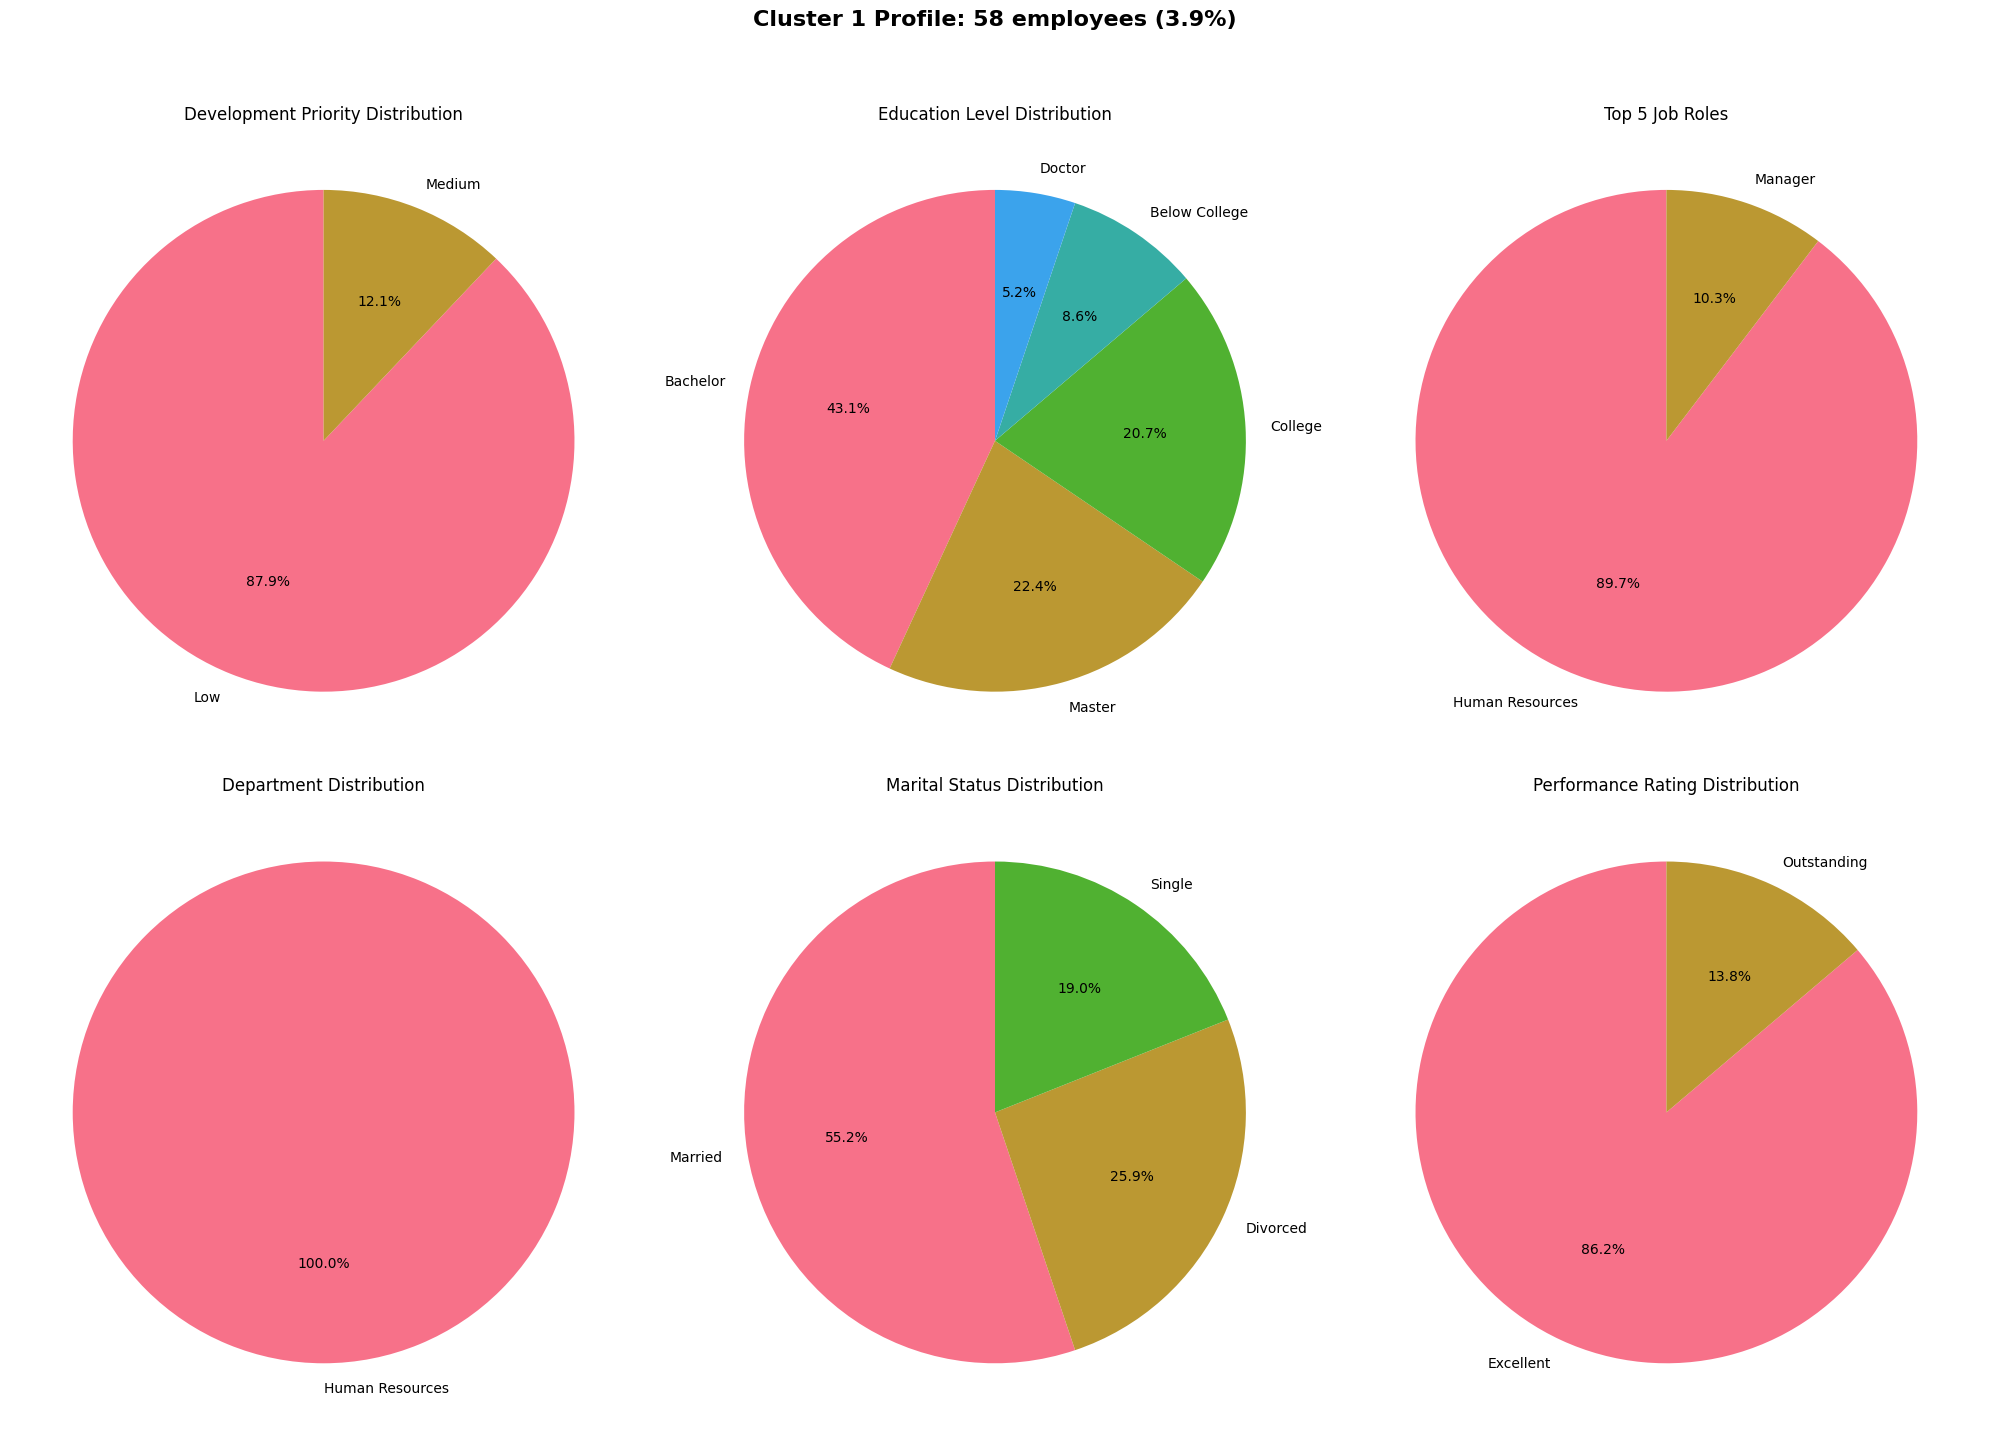


CLUSTER 1 PROFILE
Size: 58 employees (3.9%)

Key Statistics (Averages):
Age: 36.86
MonthlyIncome: 5710.28
YearsAtCompany: 6.17
YearsSinceLastPromotion: 1.50
TotalWorkingYears: 9.98
Education: 2.95
JobLevel: 1.81
PerformanceRating: 3.14
EnvironmentSatisfaction: 2.66
JobSatisfaction: 2.60
WorkLifeBalance: 2.91

Most Common Categories:
Department: Human Resources (100.0%)
EducationField: Human Resources (46.6%)
Gender: Male (67.2%)
JobRole: Human Resources (89.7%)
JobSatisfaction: 2 (29.3%)
EnvironmentSatisfaction: 3 (41.4%)

Development Priority:
Low: 87.9%
Medium: 12.1%




In [17]:
# Create detailed profile for each cluster with visualizations
for cluster_id in ibm_dataset['Cluster'].unique():
    cluster_data = ibm_dataset[ibm_dataset['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    total_employees = len(ibm_dataset)
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'Cluster {cluster_id} Profile: {cluster_size} employees ({cluster_size/total_employees*100:.1f}%)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Development Priority Pie Chart
    plt.subplot(2, 3, 1)
    dev_priority_counts = cluster_data['DevelopmentPriority'].value_counts()
    plt.pie(dev_priority_counts.values, labels=dev_priority_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Development Priority Distribution')
    
    # 2. Education Level Pie Chart
    plt.subplot(2, 3, 2)
    # Map education codes to labels for better readability
    education_labels = {
        1: 'Below College',
        2: 'College',
        3: 'Bachelor',
        4: 'Master',
        5: 'Doctor'
    }
    education_data = cluster_data['Education'].map(education_labels).value_counts()
    plt.pie(education_data.values, labels=education_data.index, autopct='%1.1f%%', startangle=90)
    plt.title('Education Level Distribution')
    
    # 3. Job Role Distribution (Top 5)
    plt.subplot(2, 3, 3)
    job_role_counts = cluster_data['JobRole'].value_counts().nlargest(5)
    plt.pie(job_role_counts.values, labels=job_role_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Top 5 Job Roles')
    
    # 4. Department Distribution
    plt.subplot(2, 3, 4)
    dept_counts = cluster_data['Department'].value_counts()
    plt.pie(dept_counts.values, labels=dept_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Department Distribution')
    
    # 5. Marital Status Distribution
    plt.subplot(2, 3, 5)
    marital_counts = cluster_data['MaritalStatus'].value_counts()
    plt.pie(marital_counts.values, labels=marital_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Marital Status Distribution')
    
    # 6. Performance Rating Distribution
    plt.subplot(2, 3, 6)
    # Map performance rating codes to labels
    performance_labels = {
        1: 'Low',
        2: 'Good',
        3: 'Excellent',
        4: 'Outstanding'
    }
    performance_data = cluster_data['PerformanceRating'].map(performance_labels).value_counts()
    plt.pie(performance_data.values, labels=performance_data.index, autopct='%1.1f%%', startangle=90)
    plt.title('Performance Rating Distribution')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
    plt.show()
    
    # Print textual information
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} PROFILE")
    print(f"Size: {cluster_size} employees ({cluster_size/total_employees*100:.1f}%)")
    print(f"{'='*60}")
    
    # Key statistics
    print("\nKey Statistics (Averages):")
    stats = cluster_data[key_features].mean()
    for feature, value in stats.items():
        print(f"{feature}: {value:.2f}")
    
    # Most common categories
    print("\nMost Common Categories:")
    for cat_var in categorical_vars:
        most_common = cluster_data[cat_var].mode()[0]
        percentage = (cluster_data[cat_var] == most_common).mean() * 100
        print(f"{cat_var}: {most_common} ({percentage:.1f}%)")
    
    # Development priority distribution
    print("\nDevelopment Priority:")
    dev_priority = cluster_data['DevelopmentPriority'].value_counts(normalize=True) * 100
    for priority, percentage in dev_priority.items():
        print(f"{priority}: {percentage:.1f}%")
    
    # Add a separator between clusters
    print(f"\n{'='*60}\n")

##### Additional Comparative Analysis across Clusters

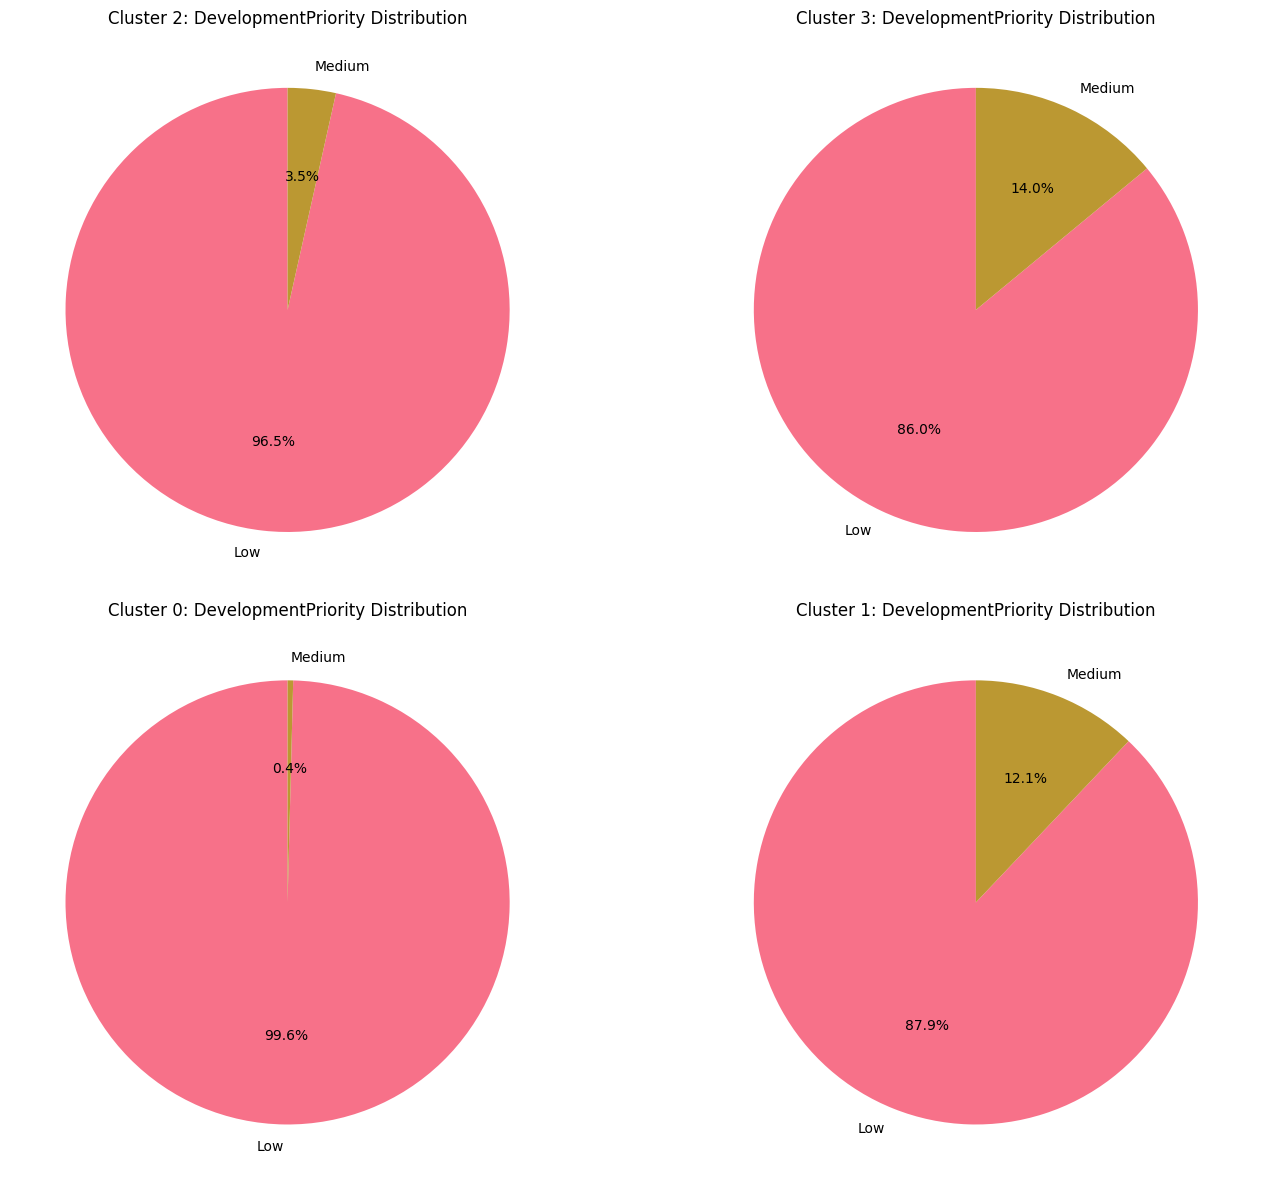

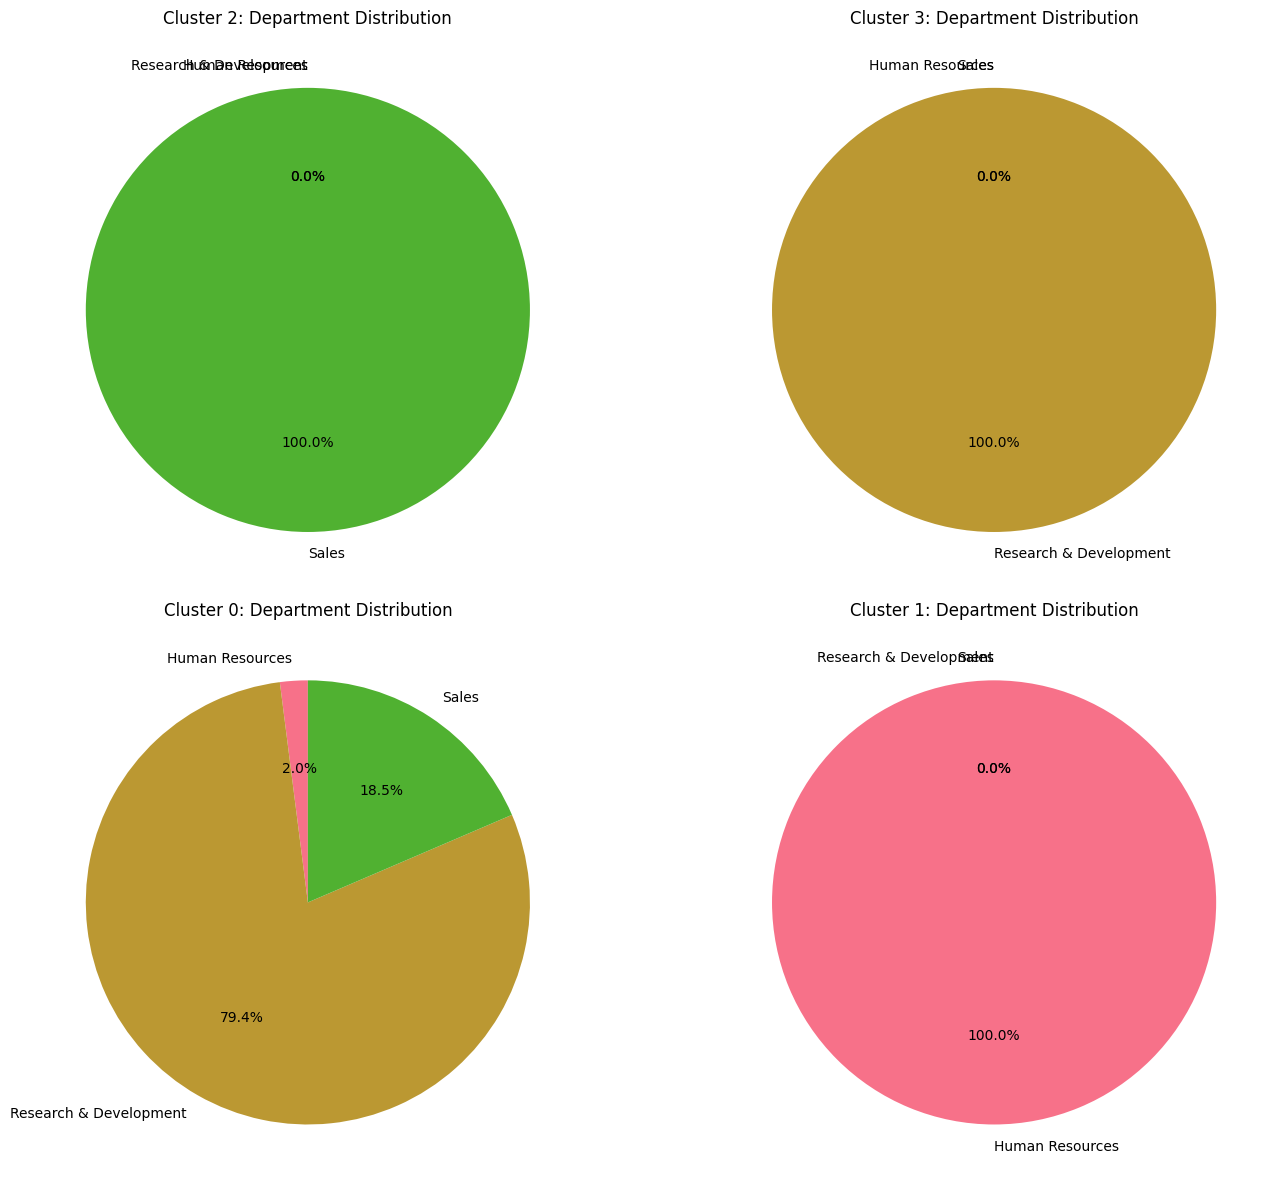

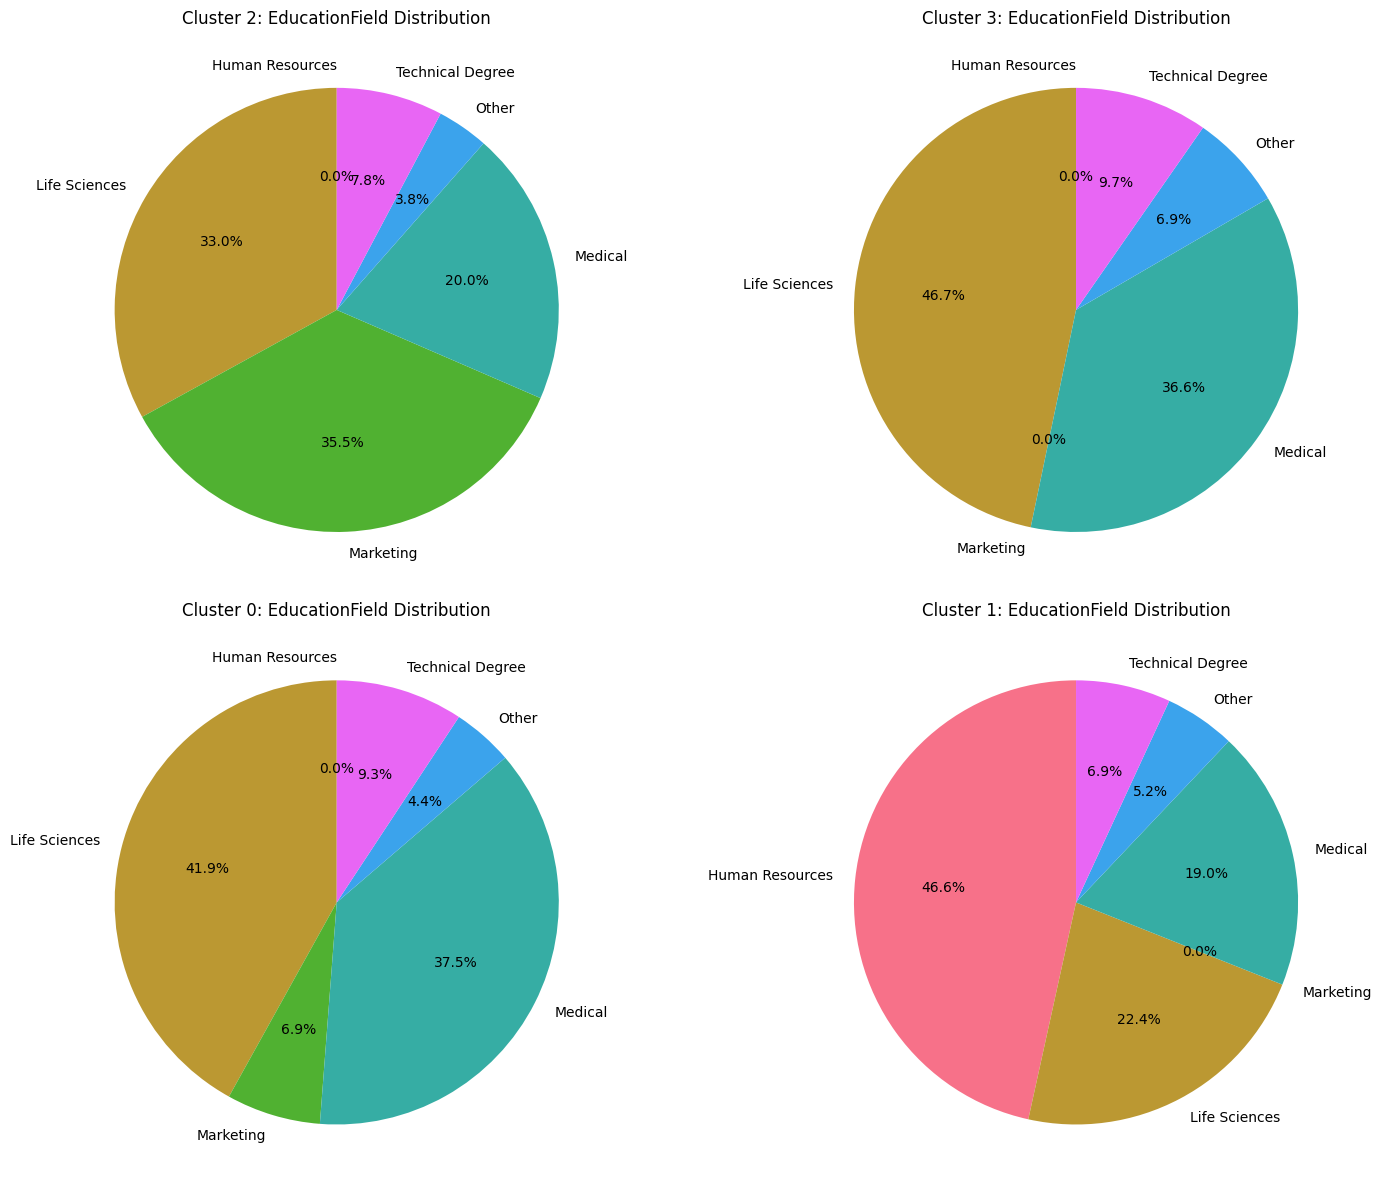

In [18]:
# Comparative pie charts across clusters for key variables
key_comparison_vars = ['DevelopmentPriority', 'Department', 'EducationField']

for var in key_comparison_vars:
    # Create a cross-tabulation of cluster vs variable
    cross_tab = pd.crosstab(ibm_dataset['Cluster'], ibm_dataset[var], normalize='index') * 100
    
    # Create a figure with subplots for each cluster
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, cluster_id in enumerate(ibm_dataset['Cluster'].unique()):
        if i < len(axes):  # Ensure we don't exceed the number of subplots
            cluster_data = cross_tab.loc[cluster_id]
            axes[i].pie(cluster_data.values, labels=cluster_data.index, autopct='%1.1f%%', startangle=90)
            axes[i].set_title(f'Cluster {cluster_id}: {var} Distribution')
    
    # Remove any empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

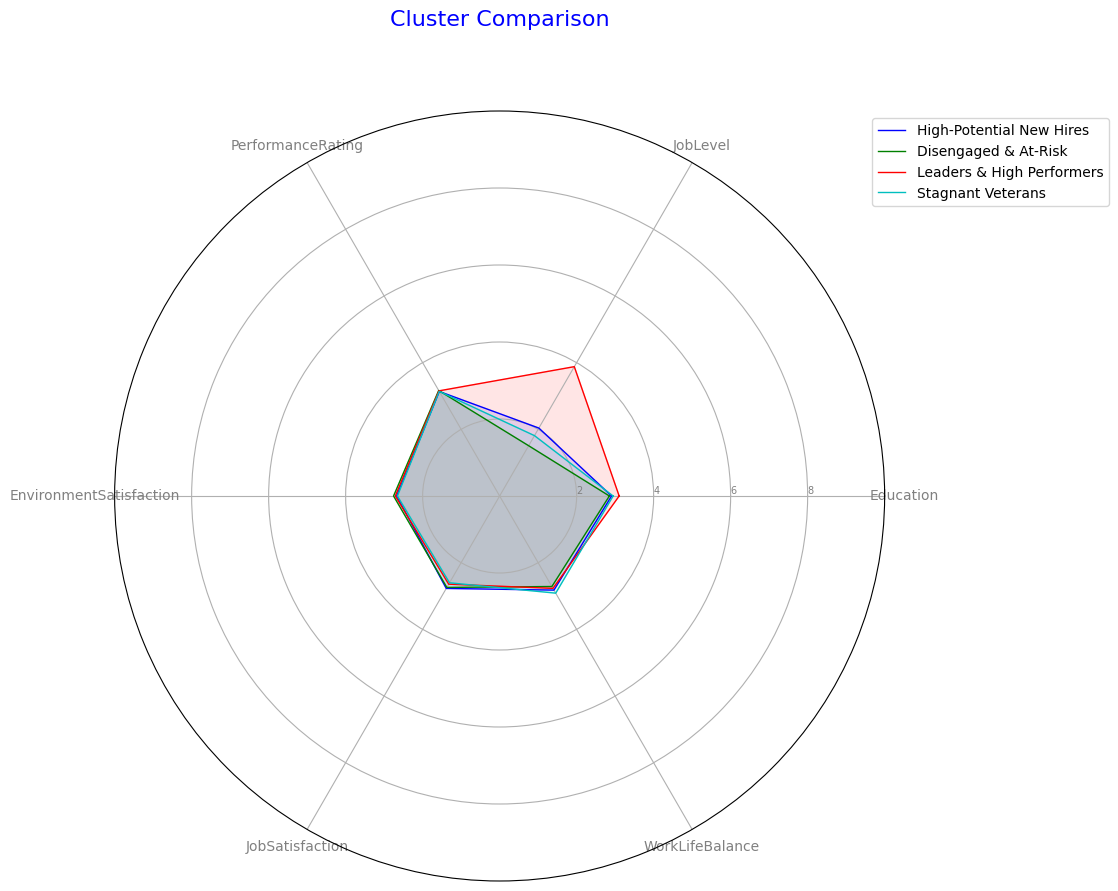

In [19]:
### Radar Metrics Chart Comparision
# Create a radar chart comparing all clusters
def create_comparative_radar_chart(df, attributes, cluster_labels=None):
    categories = attributes
    N = len(categories)
    
    # Calculate angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([2, 4, 6, 8], ["2", "4", "6", "8"], color="grey", size=7)
    plt.ylim(0, 10)
    
    # Plot data for each cluster
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
    for i, cluster_id in enumerate(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster_id][attributes].mean().values.flatten().tolist()
        cluster_data += cluster_data[:1]
        
        if cluster_labels and i < len(cluster_labels):
            label = cluster_labels[i]
        else:
            label = f'Cluster {cluster_id}'
            
        ax.plot(angles, cluster_data, linewidth=1, linestyle='solid', label=label, color=colors[i])
        ax.fill(angles, cluster_data, alpha=0.1, color=colors[i])
    
    plt.title('Cluster Comparison', size=16, color='blue', y=1.1)
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
    plt.show()

# Define the attributes to compare
radar_attributes = ['Education', 'JobLevel', 'PerformanceRating', 
                    'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']

# Create the comparative radar chart
create_comparative_radar_chart(ibm_dataset, radar_attributes, 
                               cluster_labels=['High-Potential New Hires', 'Disengaged & At-Risk', 
                                               'Leaders & High Performers', 'Stagnant Veterans'])